In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error
from tqdm import tqdm


In [3]:
with open('/home/f20222001/test-venv/UHI/Datasets_processed/inputs_36_extra_clean_40k.pkl', 'rb') as f, open('/home/f20222001/test-venv/UHI/Datasets_processed/targets_36_extra_clean_40k.pkl','rb') as t:
    inputs = pickle.load(f)
    targets = pickle.load(t)
# Shuffle before splitting (preserves alignment of X and y)
X_shuffled, y_shuffled = shuffle(inputs, targets, random_state=42)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X_shuffled, y_shuffled, test_size=0.2, random_state=42
)
# X_train, X_test, Y_train, Y_test = train_test_split(
#     X_train, Y_train, test_size=0.2, random_state=42
# )
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.25, random_state=42
)

In [4]:
# Indexes of features to normalize
norm_idx = [0, 1, 2, 3] 

# Flatten for scaling
X_train_flat = X_train.reshape(-1, X_train.shape[2])
X_val_flat   = X_val.reshape(-1, X_val.shape[2])
X_test_flat  = X_test.reshape(-1, X_test.shape[2])

# Initialize arrays to hold the scaled data
X_train_scaled = X_train_flat.copy()
X_val_scaled   = X_val_flat.copy()
X_test_scaled  = X_test_flat.copy()

scaler = StandardScaler()

# Fit on train, transform all
X_train_scaled[:, norm_idx] = scaler.fit_transform(X_train_flat[:, norm_idx])
X_val_scaled[:, norm_idx]   = scaler.transform(X_val_flat[:, norm_idx])
X_test_scaled[:, norm_idx]  = scaler.transform(X_test_flat[:, norm_idx])

# Reshape back to 3D
X_train = X_train_scaled.reshape(X_train.shape)
X_val   = X_val_scaled.reshape(X_val.shape)
X_test  = X_test_scaled.reshape(X_test.shape)

# Flatten y
y_train_flat = Y_train.reshape(-1, 1)
y_val_flat   = Y_val.reshape(-1, 1)
y_test_flat  = Y_test.reshape(-1, 1)

# Standardize y
standard_scaler_y = StandardScaler()
y_train_scaled = standard_scaler_y.fit_transform(y_train_flat)
y_val_scaled   = standard_scaler_y.transform(y_val_flat)
y_test_scaled  = standard_scaler_y.transform(y_test_flat)

# Reshape back to original shape
Y_train = y_train_scaled.reshape(Y_train.shape)
Y_val   = y_val_scaled.reshape(Y_val.shape)
Y_test  = y_test_scaled.reshape(Y_test.shape)


In [5]:
X_train.shape

(1501681, 36, 17)

In [15]:
X_train[0]

array([[-1.5065173e+00,  7.1321762e-01, -4.7059631e-01,  2.8763336e-01,
         8.6602539e-01,  5.0000000e-01,  3.8000000e+01,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         1.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [ 8.1418800e-01, -5.9889060e-01,  8.3585149e-01,  8.0978888e-01,
         8.6602539e-01, -5.0000000e-01,  4.0000000e+01,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         1.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [-5.1929891e-01,  1.0890782e+00, -7.1474355e-01,  5.4029536e-02,
        -8.6602539e-01,  5.0000000e-01,  4.6000000e+01,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         1.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [-4.2389825e-01, -1.7825599e-01,  1.1815306e-01,  5.03

In [7]:
Y_train.shape

(1501681,)

In [8]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(Y_train, dtype=torch.float32))

val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.tensor(Y_val, dtype=torch.float32))

test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(Y_test, dtype=torch.float32))

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=1024, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [9]:
device = torch.device("cuda")
torch.cuda.set_device(1)  
device

device(type='cuda')

In [10]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=1536, num_layers=3, dropout=0.3):
        super(LSTMPredictor, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size, 1)  # Output = scalar

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_size)
        last_time_step = lstm_out[:, -1, :]  # take the last time step's output
        out = self.fc(last_time_step)  # (batch_size, 1)
        return out.squeeze(1)  # final shape: (batch_size,)
    


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100 - Train Loss: 0.0684393122792244


  1%|          | 1/100 [03:18<5:28:06, 198.85s/it]

Epoch 2/100 - Train Loss: 0.06119796633720398


  2%|▏         | 2/100 [06:38<5:25:38, 199.38s/it]

Epoch 3/100 - Train Loss: 0.08322712779045105


  3%|▎         | 3/100 [09:58<5:22:35, 199.54s/it]

Epoch 4/100 - Train Loss: 0.07398693263530731


  4%|▍         | 4/100 [13:17<5:19:18, 199.57s/it]

Epoch 5/100 - Train Loss: 0.047330137342214584


  5%|▌         | 5/100 [16:37<5:15:55, 199.53s/it]

Epoch 6/100 - Train Loss: 0.06222106143832207


  6%|▌         | 6/100 [19:56<5:12:31, 199.49s/it]

Epoch 7/100 - Train Loss: 0.049085069447755814


  7%|▋         | 7/100 [23:16<5:09:13, 199.50s/it]

Epoch 8/100 - Train Loss: 0.04834309592843056


  8%|▊         | 8/100 [26:35<5:05:50, 199.47s/it]

Epoch 9/100 - Train Loss: 0.04409307241439819


  9%|▉         | 9/100 [29:55<5:02:29, 199.44s/it]

Epoch 10/100 - Train Loss: 0.03373992070555687


 10%|█         | 10/100 [33:14<4:59:07, 199.41s/it]

Epoch 11/100 - Train Loss: 0.05602734535932541


 11%|█         | 11/100 [36:33<4:55:48, 199.42s/it]

Epoch 12/100 - Train Loss: 0.028870636597275734


 12%|█▏        | 12/100 [39:52<4:52:18, 199.31s/it]

Epoch 13/100 - Train Loss: 0.030480096116662025


 13%|█▎        | 13/100 [43:12<4:48:57, 199.28s/it]

Epoch 14/100 - Train Loss: 0.029709141701459885


 14%|█▍        | 14/100 [46:31<4:45:33, 199.23s/it]

Epoch 15/100 - Train Loss: 0.02286858670413494


 15%|█▌        | 15/100 [49:50<4:42:16, 199.26s/it]

Epoch 16/100 - Train Loss: 0.05543198436498642


 16%|█▌        | 16/100 [53:09<4:38:56, 199.24s/it]

Epoch 17/100 - Train Loss: 0.029310893267393112


 17%|█▋        | 17/100 [56:29<4:35:36, 199.24s/it]

Epoch 18/100 - Train Loss: 0.02239438332617283


 18%|█▊        | 18/100 [59:48<4:32:15, 199.21s/it]

Epoch 19/100 - Train Loss: 0.02075091563165188


 19%|█▉        | 19/100 [1:03:07<4:28:58, 199.24s/it]

Epoch 20/100 - Train Loss: 0.020269667729735374


 20%|██        | 20/100 [1:06:26<4:25:39, 199.24s/it]

Epoch 21/100 - Train Loss: 0.02108079195022583


 21%|██        | 21/100 [1:09:45<4:22:17, 199.21s/it]

Epoch 22/100 - Train Loss: 0.024952474981546402


 22%|██▏       | 22/100 [1:13:05<4:18:56, 199.19s/it]

Epoch 23/100 - Train Loss: 0.01634979620575905


 23%|██▎       | 23/100 [1:16:24<4:15:37, 199.18s/it]

Epoch 24/100 - Train Loss: 0.01806030422449112


 24%|██▍       | 24/100 [1:19:43<4:12:19, 199.20s/it]

Epoch 25/100 - Train Loss: 0.015556562691926956


 25%|██▌       | 25/100 [1:23:02<4:08:56, 199.15s/it]

Epoch 26/100 - Train Loss: 0.017941836267709732


 26%|██▌       | 26/100 [1:26:21<4:05:33, 199.10s/it]

Epoch 27/100 - Train Loss: 0.01834670826792717


 27%|██▋       | 27/100 [1:29:40<4:02:15, 199.11s/it]

Epoch 28/100 - Train Loss: 0.01506456546485424


 28%|██▊       | 28/100 [1:32:59<3:58:59, 199.15s/it]

Epoch 29/100 - Train Loss: 0.010268750600516796


 29%|██▉       | 29/100 [1:36:18<3:55:37, 199.12s/it]

Epoch 30/100 - Train Loss: 0.013506053946912289


 30%|███       | 30/100 [1:39:37<3:52:18, 199.12s/it]

Epoch 31/100 - Train Loss: 0.008735577575862408


 31%|███       | 31/100 [1:42:57<3:48:58, 199.11s/it]

Epoch 32/100 - Train Loss: 0.009990491904318333


 32%|███▏      | 32/100 [1:46:16<3:45:40, 199.12s/it]

Epoch 33/100 - Train Loss: 0.010215871036052704


 33%|███▎      | 33/100 [1:49:35<3:42:22, 199.15s/it]

Epoch 34/100 - Train Loss: 0.009932772256433964


 34%|███▍      | 34/100 [1:52:54<3:39:02, 199.13s/it]

Epoch 35/100 - Train Loss: 0.011892138049006462


 35%|███▌      | 35/100 [1:56:13<3:35:42, 199.11s/it]

Epoch 36/100 - Train Loss: 0.008669156581163406


 36%|███▌      | 36/100 [1:59:32<3:32:24, 199.13s/it]

Epoch 37/100 - Train Loss: 0.013496759347617626


 37%|███▋      | 37/100 [2:02:51<3:29:03, 199.10s/it]

Epoch 38/100 - Train Loss: 0.007656233385205269


 38%|███▊      | 38/100 [2:06:10<3:25:44, 199.11s/it]

Epoch 39/100 - Train Loss: 0.008354932069778442


 39%|███▉      | 39/100 [2:09:29<3:22:24, 199.10s/it]

Epoch 40/100 - Train Loss: 0.008717602118849754


 40%|████      | 40/100 [2:12:49<3:19:06, 199.12s/it]

Epoch 41/100 - Train Loss: 0.00978765357285738


 41%|████      | 41/100 [2:16:08<3:15:45, 199.07s/it]

Epoch 42/100 - Train Loss: 0.0074422708712518215


 42%|████▏     | 42/100 [2:19:27<3:12:26, 199.08s/it]

Epoch 43/100 - Train Loss: 0.00846452172845602


 43%|████▎     | 43/100 [2:22:46<3:09:06, 199.06s/it]

Epoch 44/100 - Train Loss: 0.00822278019040823


 44%|████▍     | 44/100 [2:26:05<3:05:48, 199.08s/it]

Epoch 45/100 - Train Loss: 0.009390488266944885


 45%|████▌     | 45/100 [2:29:24<3:02:30, 199.09s/it]

Epoch 46/100 - Train Loss: 0.007490416988730431


 46%|████▌     | 46/100 [2:32:43<2:59:09, 199.07s/it]

Epoch 47/100 - Train Loss: 0.00737907225266099


 47%|████▋     | 47/100 [2:36:02<2:55:49, 199.05s/it]

Epoch 48/100 - Train Loss: 0.007483714260160923


 48%|████▊     | 48/100 [2:39:21<2:52:31, 199.07s/it]

Epoch 49/100 - Train Loss: 0.007669123355299234


 49%|████▉     | 49/100 [2:42:40<2:49:11, 199.05s/it]

Epoch 50/100 - Train Loss: 0.0064886100590229034


 50%|█████     | 50/100 [2:45:59<2:45:50, 199.01s/it]

Epoch 51/100 - Train Loss: 0.0061600105836987495


 51%|█████     | 51/100 [2:49:18<2:42:30, 198.99s/it]

Epoch 52/100 - Train Loss: 0.007780507672578096


 52%|█████▏    | 52/100 [2:52:37<2:39:09, 198.94s/it]

Epoch 53/100 - Train Loss: 0.007945521734654903


 53%|█████▎    | 53/100 [2:55:56<2:35:52, 199.00s/it]

Epoch 54/100 - Train Loss: 0.006384664680808783


 54%|█████▍    | 54/100 [2:59:15<2:32:33, 198.99s/it]

Epoch 55/100 - Train Loss: 0.005710989236831665


 55%|█████▌    | 55/100 [3:02:34<2:29:13, 198.96s/it]

Epoch 56/100 - Train Loss: 0.016071714460849762


 56%|█████▌    | 56/100 [3:05:53<2:25:53, 198.95s/it]

Epoch 57/100 - Train Loss: 0.006666987203061581


 57%|█████▋    | 57/100 [3:09:12<2:22:35, 198.97s/it]

Epoch 58/100 - Train Loss: 0.0056474641896784306


 58%|█████▊    | 58/100 [3:12:31<2:19:15, 198.95s/it]

Epoch 59/100 - Train Loss: 0.005901277530938387


 59%|█████▉    | 59/100 [3:15:50<2:15:55, 198.93s/it]

Epoch 60/100 - Train Loss: 0.005631573963910341


 60%|██████    | 60/100 [3:19:09<2:12:38, 198.97s/it]

Epoch 61/100 - Train Loss: 0.006780080962926149


 61%|██████    | 61/100 [3:22:28<2:09:22, 199.05s/it]

Epoch 62/100 - Train Loss: 0.005756244529038668


 62%|██████▏   | 62/100 [3:25:47<2:06:05, 199.09s/it]

Epoch 63/100 - Train Loss: 0.005720349494367838


 63%|██████▎   | 63/100 [3:29:06<2:02:47, 199.13s/it]

Epoch 64/100 - Train Loss: 0.006521645933389664


 64%|██████▍   | 64/100 [3:32:25<1:59:29, 199.14s/it]

Epoch 65/100 - Train Loss: 0.005196890793740749


 65%|██████▌   | 65/100 [3:35:45<1:56:11, 199.20s/it]

Epoch 66/100 - Train Loss: 0.005951789673417807


 66%|██████▌   | 66/100 [3:39:04<1:52:52, 199.20s/it]

Epoch 67/100 - Train Loss: 0.004829830024391413


 67%|██████▋   | 67/100 [3:42:23<1:49:33, 199.19s/it]

Epoch 68/100 - Train Loss: 0.006051643285900354


 68%|██████▊   | 68/100 [3:45:42<1:46:13, 199.17s/it]

Epoch 69/100 - Train Loss: 0.004825918469578028


 69%|██████▉   | 69/100 [3:49:02<1:42:55, 199.22s/it]

Epoch 70/100 - Train Loss: 0.005220435094088316


 70%|███████   | 70/100 [3:52:21<1:39:36, 199.20s/it]

Epoch 71/100 - Train Loss: 0.004359596408903599


 71%|███████   | 71/100 [3:55:40<1:36:16, 199.19s/it]

Epoch 72/100 - Train Loss: 0.005755600053817034


 72%|███████▏  | 72/100 [3:58:59<1:32:56, 199.18s/it]

Epoch 73/100 - Train Loss: 0.004831703845411539


 73%|███████▎  | 73/100 [4:02:18<1:29:37, 199.15s/it]

Epoch 74/100 - Train Loss: 0.00620634900406003


 74%|███████▍  | 74/100 [4:05:37<1:26:18, 199.18s/it]

Epoch 75/100 - Train Loss: 0.005797560792416334


 75%|███████▌  | 75/100 [4:08:56<1:22:56, 199.06s/it]

Epoch 76/100 - Train Loss: 0.005163528490811586


 76%|███████▌  | 76/100 [4:12:15<1:19:35, 198.97s/it]

Epoch 77/100 - Train Loss: 0.006090856622904539


 77%|███████▋  | 77/100 [4:15:34<1:16:15, 198.94s/it]

Epoch 78/100 - Train Loss: 0.004833349958062172


 78%|███████▊  | 78/100 [4:18:53<1:12:57, 199.00s/it]

Epoch 79/100 - Train Loss: 0.004588762763887644


 79%|███████▉  | 79/100 [4:22:12<1:09:37, 198.94s/it]

Epoch 80/100 - Train Loss: 0.004760284908115864


 80%|████████  | 80/100 [4:25:31<1:06:18, 198.93s/it]

Epoch 81/100 - Train Loss: 0.004394227173179388


 81%|████████  | 81/100 [4:28:50<1:03:01, 199.02s/it]

Epoch 82/100 - Train Loss: 0.004879349377006292


 82%|████████▏ | 82/100 [4:32:09<59:43, 199.06s/it]  

Epoch 83/100 - Train Loss: 0.004314196761697531


 83%|████████▎ | 83/100 [4:35:28<56:25, 199.13s/it]

Epoch 84/100 - Train Loss: 0.004477557260543108


 84%|████████▍ | 84/100 [4:38:47<53:06, 199.15s/it]

Epoch 85/100 - Train Loss: 0.0052030980587005615


 85%|████████▌ | 85/100 [4:42:07<49:47, 199.18s/it]

Epoch 86/100 - Train Loss: 0.0057504610158503056


 86%|████████▌ | 86/100 [4:45:26<46:29, 199.23s/it]

Epoch 87/100 - Train Loss: 0.005631165113300085


 87%|████████▋ | 87/100 [4:48:45<43:09, 199.18s/it]

Epoch 88/100 - Train Loss: 0.0044061122462153435


 88%|████████▊ | 88/100 [4:52:04<39:49, 199.10s/it]

Epoch 89/100 - Train Loss: 0.004598669242113829


 89%|████████▉ | 89/100 [4:55:23<36:29, 199.07s/it]

Epoch 90/100 - Train Loss: 0.004637346602976322


 90%|█████████ | 90/100 [4:58:42<33:10, 199.08s/it]

Epoch 91/100 - Train Loss: 0.009954407811164856


 91%|█████████ | 91/100 [5:02:01<29:51, 199.10s/it]

Epoch 92/100 - Train Loss: 0.006597473286092281


 92%|█████████▏| 92/100 [5:05:20<26:32, 199.06s/it]

Epoch 93/100 - Train Loss: 0.004229285288602114


 93%|█████████▎| 93/100 [5:08:39<23:13, 199.05s/it]

Epoch 94/100 - Train Loss: 0.004214220680296421


 94%|█████████▍| 94/100 [5:11:58<19:54, 199.05s/it]

Epoch 95/100 - Train Loss: 0.004318181425333023


 95%|█████████▌| 95/100 [5:15:18<16:35, 199.09s/it]

Epoch 96/100 - Train Loss: 0.0038057623896747828


 96%|█████████▌| 96/100 [5:18:36<13:16, 199.04s/it]

Epoch 97/100 - Train Loss: 0.004148493520915508


 97%|█████████▋| 97/100 [5:21:55<09:56, 198.88s/it]

Epoch 98/100 - Train Loss: 0.005303935147821903


 98%|█████████▊| 98/100 [5:25:13<06:37, 198.78s/it]

Epoch 99/100 - Train Loss: 0.004135787021368742


 99%|█████████▉| 99/100 [5:28:32<03:18, 198.77s/it]

Epoch 100/100 - Train Loss: 0.004369296133518219


100%|██████████| 100/100 [5:31:51<00:00, 199.11s/it]


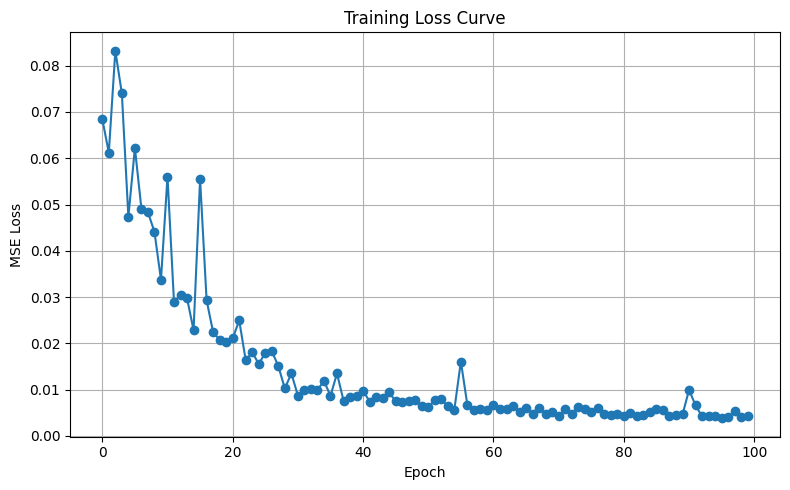

In [11]:
input_size = X_train.shape[2]  # num_features per timestep
model = LSTMPredictor(input_size=input_size)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Training loop
num_epochs = 100
train_losses = []
val_losses = {
    "mse": [],
    "rmse": [],
    "mae": [],
    "r2": []
}

for epoch in tqdm(range(num_epochs)):
    model.train()

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        #print(batch_x.shape)
        #print(batch_y.shape)
        # Forward
        preds = model(batch_x)  # shape: (batch_size,)
        #print(preds.shape)
        loss = criterion(preds, batch_y)
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {loss.item()}")
    train_losses.append(loss.item())

    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x = val_x.to(device)
            val_y = val_y.to(device)

            preds = model(val_x)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(val_y.cpu().numpy())

    # Concatenate and inverse scale
    all_preds_np = np.concatenate(all_preds).reshape(-1, 1)
    all_targets_np = np.concatenate(all_targets).reshape(-1, 1)

    y_pred = standard_scaler_y.inverse_transform(all_preds_np)
    y_true = standard_scaler_y.inverse_transform(all_targets_np)

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    val_losses["mse"].append(mse)
    val_losses["rmse"].append(rmse)
    val_losses["mae"].append(mae)
    val_losses["r2"].append(r2)


plt.figure(figsize=(8, 5))
plt.plot(np.arange(num_epochs),train_losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        preds = model(batch_x)
        
        y_true.extend(batch_y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true).reshape(-1, 1)
y_pred = np.array(y_pred).reshape(-1, 1)

# Unnormalize using RobustScaler
y_true = standard_scaler_y.inverse_transform(y_true)
y_pred = standard_scaler_y.inverse_transform(y_pred)

# Flatten back
y_true = y_true.flatten()
y_pred = y_pred.flatten()

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape=mean_absolute_percentage_error(y_true, y_pred)
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test R²:   {r2:.4f}")
print(f"Test MAPE:   {mape:.4f}")

Test MSE:  1.6674
Test RMSE: 1.2913
Test MAE:  0.6923
Test R²:   0.9786
Test MAPE:   0.0303


In [13]:
val_losses['mae']

[1.5036803483963013,
 1.4103403091430664,
 1.3851362466812134,
 1.3214991092681885,
 1.2399308681488037,
 1.2260042428970337,
 1.1539329290390015,
 1.1631054878234863,
 1.1216756105422974,
 1.0578168630599976,
 1.0517606735229492,
 1.0035420656204224,
 1.0337374210357666,
 0.9953300952911377,
 0.9943916201591492,
 0.9553926587104797,
 0.9502241611480713,
 0.9309963583946228,
 0.9043785929679871,
 0.8999581933021545,
 0.9130896925926208,
 0.8760199546813965,
 0.874247670173645,
 0.8630198240280151,
 0.8573884963989258,
 0.8583336472511292,
 0.8891017436981201,
 0.8392676115036011,
 0.8343034386634827,
 0.8270436525344849,
 0.8136557936668396,
 0.7927205562591553,
 0.8052173256874084,
 0.7954936623573303,
 0.8066961169242859,
 0.7781433463096619,
 0.77186518907547,
 0.7764392495155334,
 0.7761554718017578,
 0.7656976580619812,
 0.7749698758125305,
 0.7633377313613892,
 0.7671017646789551,
 0.7488188147544861,
 0.7782840132713318,
 0.7537875175476074,
 0.744956910610199,
 0.75143146514892

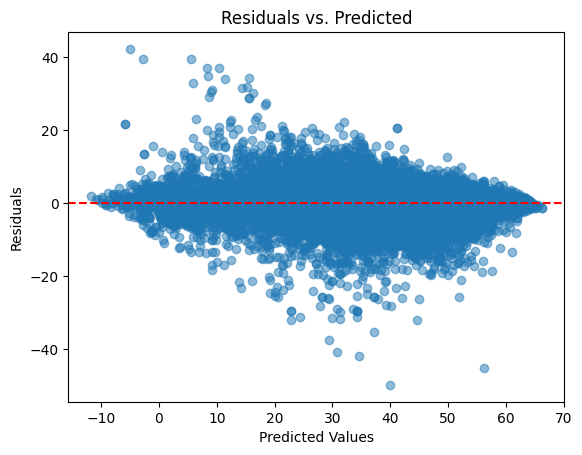

In [14]:
residuals=y_true-y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted')
plt.show()


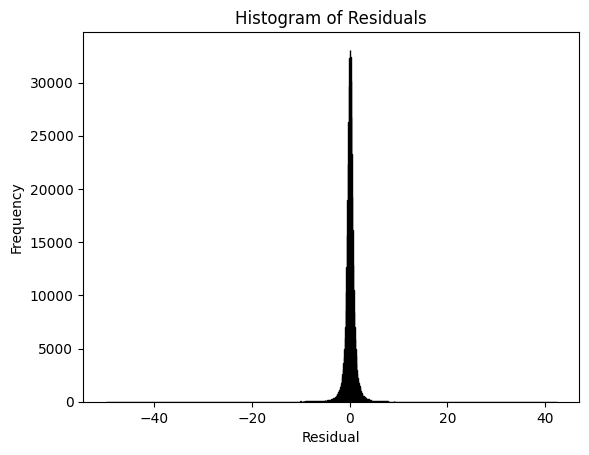

In [24]:
plt.hist(residuals, bins=1000, edgecolor='black')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


In [28]:
len(residuals[np.abs(residuals)>10])*100/len(residuals)

0.1855917660385048

In [25]:
rmse = np.sqrt(np.mean((residuals) ** 2))
large_errors = residuals[np.abs(residuals) > 2 * rmse]
print(f"Number of large residuals: {len(large_errors)}")


Number of large residuals: 18307


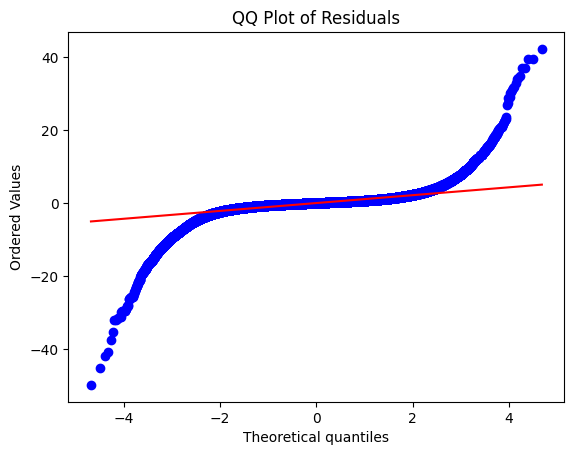

In [26]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.show()
